In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# **Load Data**

In [2]:
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print(dataset_df.head(5))
print(dataset_df.describe())
print(dataset_df.columns)


  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  
  

**Data Exploration**

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Deck', 'Cabin_num', 'Side']
PassengerId  HomePlanet  CryoSleep  Destination  VIP    Name                Deck  Cabin_num  Side
0001_01      Europa      False      TRAPPIST-1e  False  Maham Ofracculy     B     0          P       1
6137_05      Earth       True       TRAPPIST-1e  False  Loree Serry         G     994        S       1
6148_02      Mars        True       TRAPPIST-1e  False  Pikes Sueke         F     1176       S       1
6148_01      Mars        True       TRAPPIST-1e  False  Jagice Sueke        F     1176       S       1
6146_01      Europa      False      TRAPPIST-1e  False  Scelava Groforacid  B     207        P       1
                                                                                                    ..
3149_01      Earth       False      TRAPPIST-1e  False  Natha Portananney   G     494        S       1
3147_01      Earth       False      TRAPPIST-1e  False  Colle Steinardson   F  

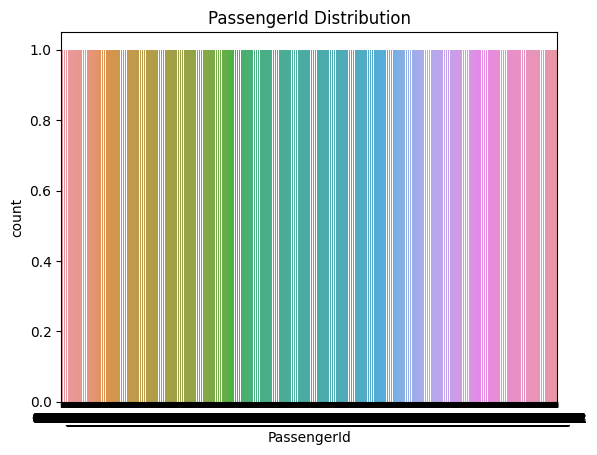

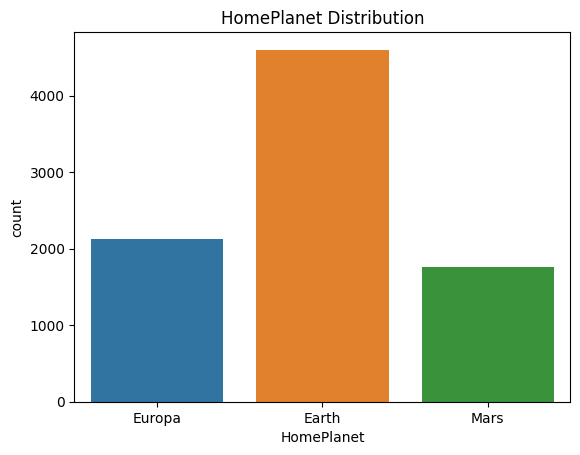

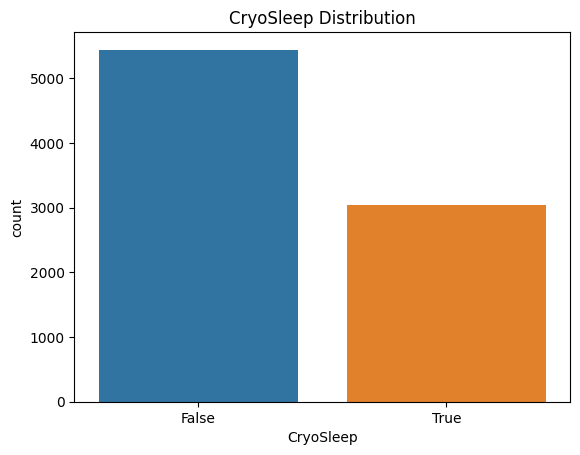

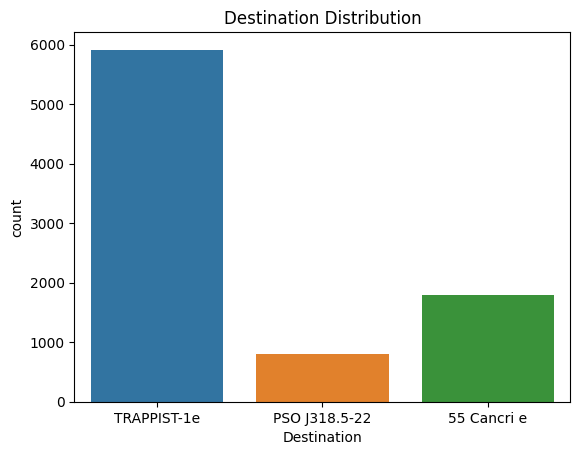

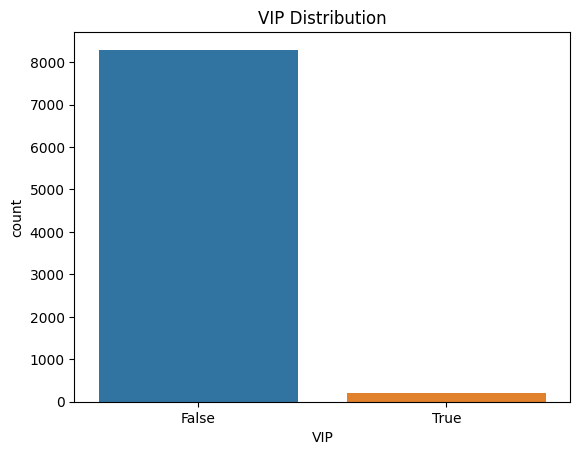

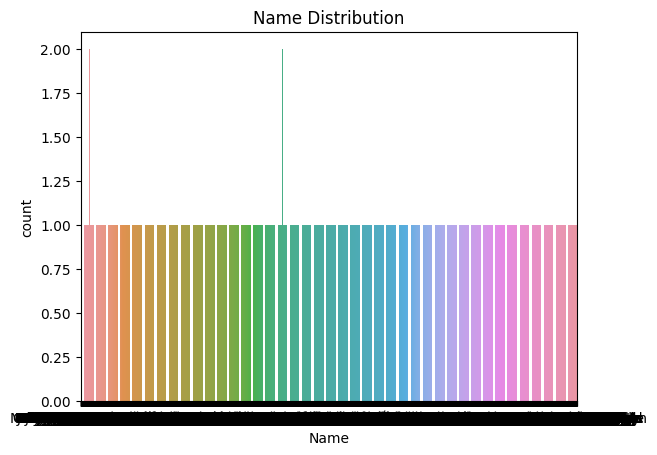

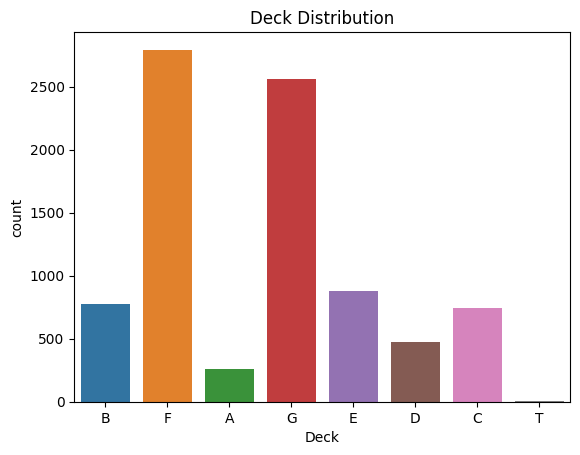

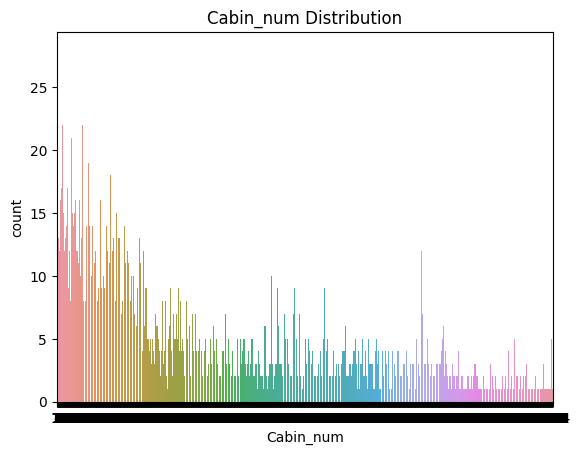

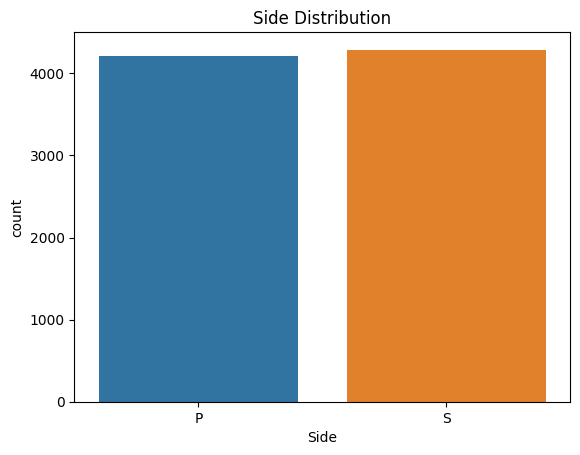

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt
# Get the categorical features from the DataFrame
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
dataset_df = dataset_df.drop('Cabin', axis=1)
categorical_features = dataset_df.select_dtypes(include=[ 'object']).columns.tolist()
print(categorical_features)

# Print value counts for the categorical features
for feature in categorical_features:
    print(dataset_df[categorical_features].value_counts())

# Visualize the distributions of the categorical features using countplots
for feature in categorical_features:
    sns.countplot(x=feature, data=dataset_df)
    plt.title(f"{feature} Distribution")
    plt.show()


In [4]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)


In [5]:
missing_percentages = (dataset_df.isnull().sum() / len(dataset_df)) * 100

# Print the missing percentages for each column
print(missing_percentages)

HomePlanet      2.312205
CryoSleep       2.496261
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Transported     0.000000
Deck            2.289198
Cabin_num       2.289198
Side            2.289198
dtype: float64


**Data Preprocessing**

In [6]:
from sklearn.preprocessing import LabelEncoder

# Select categorical features
cat_features = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'Deck', 'Cabin_num', 'Side']



# Initialize the LabelEncoder
le = LabelEncoder()

# Impute missing categorical values with mode
for feature in cat_features:
    dataset_df[feature].fillna(dataset_df[feature].mode()[0], inplace=True)

# Encode categorical features with label encoding
for feature in cat_features:
    dataset_df[feature] = le.fit_transform(dataset_df[feature])

# Impute missing numerical values with median
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for feature in num_features:
    #  dataset_df[feature].fillna(0, inplace=True)
    dataset_df[feature].fillna(dataset_df[feature].mean(), inplace=True)

# Print the updated DataFrame
print(dataset_df[['Deck', 'Cabin_num', 'Side']])



      Deck  Cabin_num  Side
0        1          0     0
1        5          0     1
2        0          0     1
3        0          0     1
4        5          1     1
...    ...        ...   ...
8688     0       1795     0
8689     6        548     1
8690     6        551     1
8691     4       1385     1
8692     4       1385     1

[8693 rows x 3 columns]


 **Hyperparameter Tuning**

In [7]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}

# Create a SVM classifier
svm = SVC()

# Create a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(svm, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Predict the labels of the test data using the best estimator found by GridSearchCV
y_pred = grid_search.predict(X_test)

# Print a classification report for the predicted labels
print("Classification report for the best estimator found by GridSearchCV:")
print(classification_report(y_test, y_pred))


NameError: name 'X_train' is not defined

In [ ]:
# Load the test data
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
best_model = grid_search.best_estimator_
# Extract the first letter of the cabin number and split it into Deck, Cabin_num, and Side
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)
submission_id = test_df['PassengerId']
test_df = test_df.drop(['PassengerId', 'Name'], axis=1)

# Select categorical features
cat_features = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep','Cabin_num', 'Deck', 'Side']

# Initialize the LabelEncoder
le = LabelEncoder()

# Impute missing categorical values with mode
for feature in cat_features:
    test_df[feature].fillna( test_df[feature].mode()[0], inplace=True)

# Encode categorical features with label encoding
for feature in cat_features:
    test_df[feature] = le.fit_transform(test_df[feature])

# Impute missing numerical values with median
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for feature in num_features:
    test_df[feature].fillna( test_df[feature].median(), inplace=True)

# Make predictions on test data
predictions =best_model.predict(test_df)
n_predictions = (predictions > 0.5).astype(bool)

# Create submission file

output = pd.DataFrame({'PassengerId': submission_id, 'Transported': n_predictions})
output.to_csv('submission.csv', index=False)
print(output.head(5))
